# Predicción de la calificación crediticia mediante Machine Learning
## Uso de redes neuronales para predecir el rating crediticio
### Análisis de calificación crediticia para BIMBO (BMV: BIMBOA)
#### Reto con socioformador Bimbo
###### Diego Arturo Salazar Silva
###### Tecnológico de Monterrey Campus Monterrey

**Introducción:**

Este notebook presenta los resultados del análisis de datos realizado sobre un conjunto de calificaciones crediticias corporativas asignadas por agencias calificadoras a diversas empresas. El objetivo principal de este análisis es desarrollar un modelo de machine learning que permita predecir la calificación que una empresa recibirá basada en los datos de calificación.

La primera sección del notebook se centra en el análisis exploratorio de datos, donde se exploran y comprenden las características del conjunto de datos. Se examina cada variable para entender su naturaleza y distribución, así como la correlación entre las distintas variables a través de análisis visual.

En la segunda sección, se lleva a cabo el desarrollo del modelo de machine learning. Se prueban múltiples algoritmos y se compara su rendimiento. Después, se selecciona el mejor modelo y se realiza un ajuste de hiperparámetros.

Durante la evaluación del modelo, se utilizan diversas técnicas, como la matriz de confusión y métricas como F1. Así mismo, se analizan los factores más importantes de los modelos.

**Base de Datos:**.

La base de datos incluye información sobre las empresas que forman parte de los índices S&P 500, Russell 3000, Nikkei 225, FTSE 100 y IPC 35. Los parámetros se agrupan de la siguiente manera:

- **Múltiplos:** PE, PBV, EV/EBITDA, EV/SALES, EV/BV, EV/IC.
- **Márgenes:** EBITDA Margin, EBIT Margin, Net Profit Margin.
- **Deuda y Capital:** WACC, Debt Capital, Current Ratio, Quick Ratio.
- **Rendimiento y Crecimiento:** Dividend Yield, DPS/EPS, EPS Growth, ROE.
- **Riesgo y Volatilidad:** Beta, Fscore, Z-Score (Altman).
- **Flujo de Caja y Rentabilidad:** FCFFperShare, ROIC, Tax Rate, Working Capital (WC), EBIT.
- **Datos Financieros:** Market Cap, Assets, Liabilities, Revenue.

Para mayor información de que significa cada variable, revisar el archivo README.

El estudio tiene un enfoque mayor en la red neuronal creada para predecir el rating crediticio de las empresas. Debido a que era el modelo más certero.

Principalmente los modelos presentados en este notebook, están hechos con apoyo de la librería sklearn.

Inspirado en: https://github.com/Agewerc/ML-Finance/blob/master/corporateCreditRatingPrediction.ipynb

In [212]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from numpy import sort
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from wordcloud import WordCloud, STOPWORDS
from random import sample
import seaborn as sns
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from xgboost import XGBClassifier


In [213]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [214]:
df = pd.read_excel('/Users/diegosalazar/Documents/Valuación de Empresas/Modulo 2/BimboNuevo.xlsx')

### Limpieza de datos

En esta sección se realiza una simple limpieza de la base de datos, se eliminan los valores faltantes (NAs) y columnas no tan relevantes. Un aspecto importante del código es que, por motivos de simplificación, las calificaciones crediticias de la base de datos, se dividen en 3 categorías: Riesgo Alto, Bajo y Medio (High risk, low risk y medium risk) En lugar de utilizar la forma convencional de calificar a las empresas.

Así mismo, se crea la columna de Z-Score, una medida muy importante al momento de evaluar la solvencia de la empresa.


In [142]:
print(f"La base de datos tiene {df.shape[0]}, lineas, cada uno con, {df.shape[1]} columnas")

La base de datos tiene 3033, lineas, cada uno con, 34 columnas


In [215]:
df = df.drop(['DividendYield'], axis=1) #Se elimina la columna porque tiene muchos NAs

In [144]:
print(f"La base de datos tiene {df.shape[0]}, lineas, cada uno con, {df.shape[1]} columnas")


La base de datos tiene 3033, lineas, cada uno con, 33 columnas


In [216]:
df = df.dropna()


In [146]:
print(f"La base de datos tiene {df.shape[0]}, lineas, cada uno con, {df.shape[1]} columnas")


La base de datos tiene 618, lineas, cada uno con, 33 columnas


In [217]:
df.Rating.value_counts()

Rating
A1+           49
A1            48
Baa2          44
Ba2           34
NR            33
              ..
LGD4 - 55%     1
Aaa            1
LGD4 - 62%     1
LGD3 - 45%     1
AA+(mex)       1
Name: count, Length: 68, dtype: int64

In [218]:
rating_dict = {
    'A1': 'Low Risk',
    'A1+': 'Low Risk',
    'Baa2': 'Medium Risk',
    'NR': 'Medium Risk', #Nota: para facilitar el proceso de la recopilación de datos, las 33 empresas sin rating, se añadieron como 'Medium Risk'
    'Ba2': 'High Risk',
    'WR': 'Low Risk', #Nota: para facilitar el proceso de la recopilación de datos, las 30 empresas con WR, se añadieron como 'Low Risk'
    'Baa3': 'Medium Risk',
    'Baa1': 'Medium Risk',
    'BBB': 'Medium Risk',
    'BBB-': 'Medium Risk',
    'B1': 'High Risk',
    'Ba1': 'High Risk',
    'P-2': 'Medium Risk',
    'A2': 'Low Risk',
    'Ba3': 'High Risk',
    'A': 'Low Risk',
    'A+': 'Low Risk',
    'BBB+': 'Medium Risk',
    'A3': 'Low Risk',
    'BB+': 'High Risk',
    'BB': 'High Risk',
    'P-1': 'Low Risk',
    'B+': 'High Risk',
    'A-': 'Low Risk',
    'F2': 'Medium Risk',
    'WD': 'Low Risk',
    'B-': 'High Risk',
    'Aa3': 'Low Risk',
    'BB-': 'High Risk',
    'F3': 'Medium Risk',
    'F1': 'Low Risk',
    'Aa2': 'Low Risk',
    'B2': 'High Risk',
    'AA-': 'Low Risk',
    'B3': 'High Risk',
    'LGD5 - 76%': 'Medium Risk',
    'SGL-2': 'Low Risk',
    'LGD5 - 74%': 'Medium Risk',
    'P-3': 'Medium Risk',
    'AAA(mex)': 'Low Risk',
    'B': 'High Risk',
    'LGD3 - 38%': 'High Risk',
    'LGD3 - 39%': 'High Risk',
    '(P)A2': 'Low Risk',
    'F1+(mex)': 'Low Risk',
    'LGD2 - 19%': 'High Risk',
    'LGD5 - 80%': 'Medium Risk',
    'LGD5 - 78%': 'Medium Risk',
    'LGD2 - 13%': 'High Risk',
    'LGD4 - 64%': 'Medium Risk',
    'LGD5 - 71%': 'Medium Risk',
    '(P)Baa3': 'Medium Risk',
    'LGD5 - 73%': 'Medium Risk',
    'LGD2 - 29%': 'High Risk',
    'AA': 'Low Risk',
    'LGD4 - 61%': 'Medium Risk',
    'LGD2 - 24%': 'High Risk',
    'LGD3 - 33%': 'High Risk',
    'LGD3 - 30%': 'High Risk',
    'LGD5 - 72%': 'Medium Risk',
    'LGD4 - 54%': 'Medium Risk',
    'LGD4 - 57%': 'Medium Risk',
    'LGD6 - 90%': 'Low Risk',
    'LGD2 - 23%': 'High Risk',
    'LGD5 - 75%': 'Medium Risk',
    'LGD4 - 69%': 'Medium Risk',
    'LGD5 - 81%': 'Low Risk',
    'LGD4 - 55%': 'Medium Risk',
    'Aaa': 'Low Risk',
    'LGD3 - 31%': 'High Risk',
    'AA+(mex)': 'Low Risk'
}
df.Rating = df.Rating.map(rating_dict)

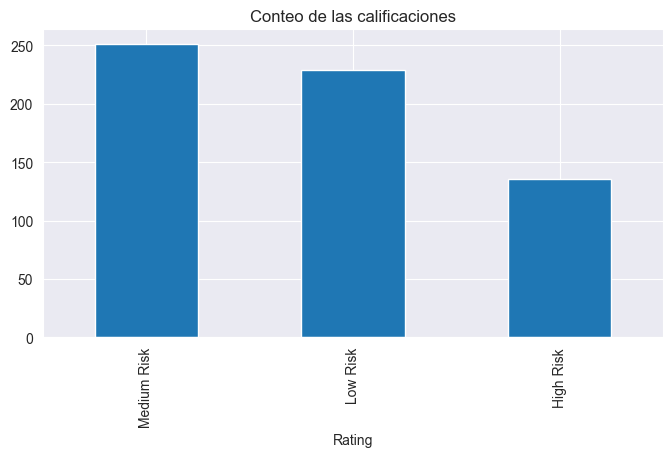

In [219]:
ax = df['Rating'].value_counts().plot(kind='bar',
                                             figsize=(8,4),
                                             title="Conteo de las calificaciones",
                                             grid=True)

In [220]:
df['Z-score'] = 1.2 * df['WC']/df['Assets'] + 1.4 * df['RE']/df['Assets'] + 3.3 * df['EBIT']/df['Assets'] + 0.6 * df['Market_Cap']/df['Liabalities'] + 1 * df['Revenue']/df['Assets']

In [221]:
df = df.drop(['Ticker'], axis=1)


### Estandarización de los datos

Para que el modelo funcione, es fundamental que los datos estén estandárizados. Esto se realiza con el objetivo que todos los valores estén dentro de la misma magnitud.


In [222]:
min_max_scaler = preprocessing.MinMaxScaler()

columns_to_scale = df.columns[np.r_[4:32]]

for c in columns_to_scale:
    df[[c]] = min_max_scaler.fit_transform(df[[c]]) * 1000
    df[c] = df[c].apply(lambda x: np.log10(x + 0.01))

### Análisis exploratorio

En esta sección, se realiza un análisis exploratorio de los datos, se observa la distribución de cada variable, y un diagrama de puntos que pretende analizar como se comportan los fundamentos dependiendo del tipo de rating de la empresa.

In [153]:
df_rating_no_out = df.copy()

columns_to_scale = df_rating_no_out.columns[np.r_[4:32]]
for c in columns_to_scale:
    q05 = df_rating_no_out[c].quantile(0.10)
    q95 = df_rating_no_out[c].quantile(0.90)
    iqr = q95 - q05
    fence_low  = q05-1.5*iqr
    fence_high = q95+1.5*iqr
    df_rating_no_out.loc[df_rating_no_out[c] > fence_high,c] = df_rating_no_out[c].quantile(0.25)
    df_rating_no_out.loc[df_rating_no_out[c] < fence_low,c] = df_rating_no_out[c].quantile(0.75)

IndexError: index 8 is out of bounds for axis 0 with size 8

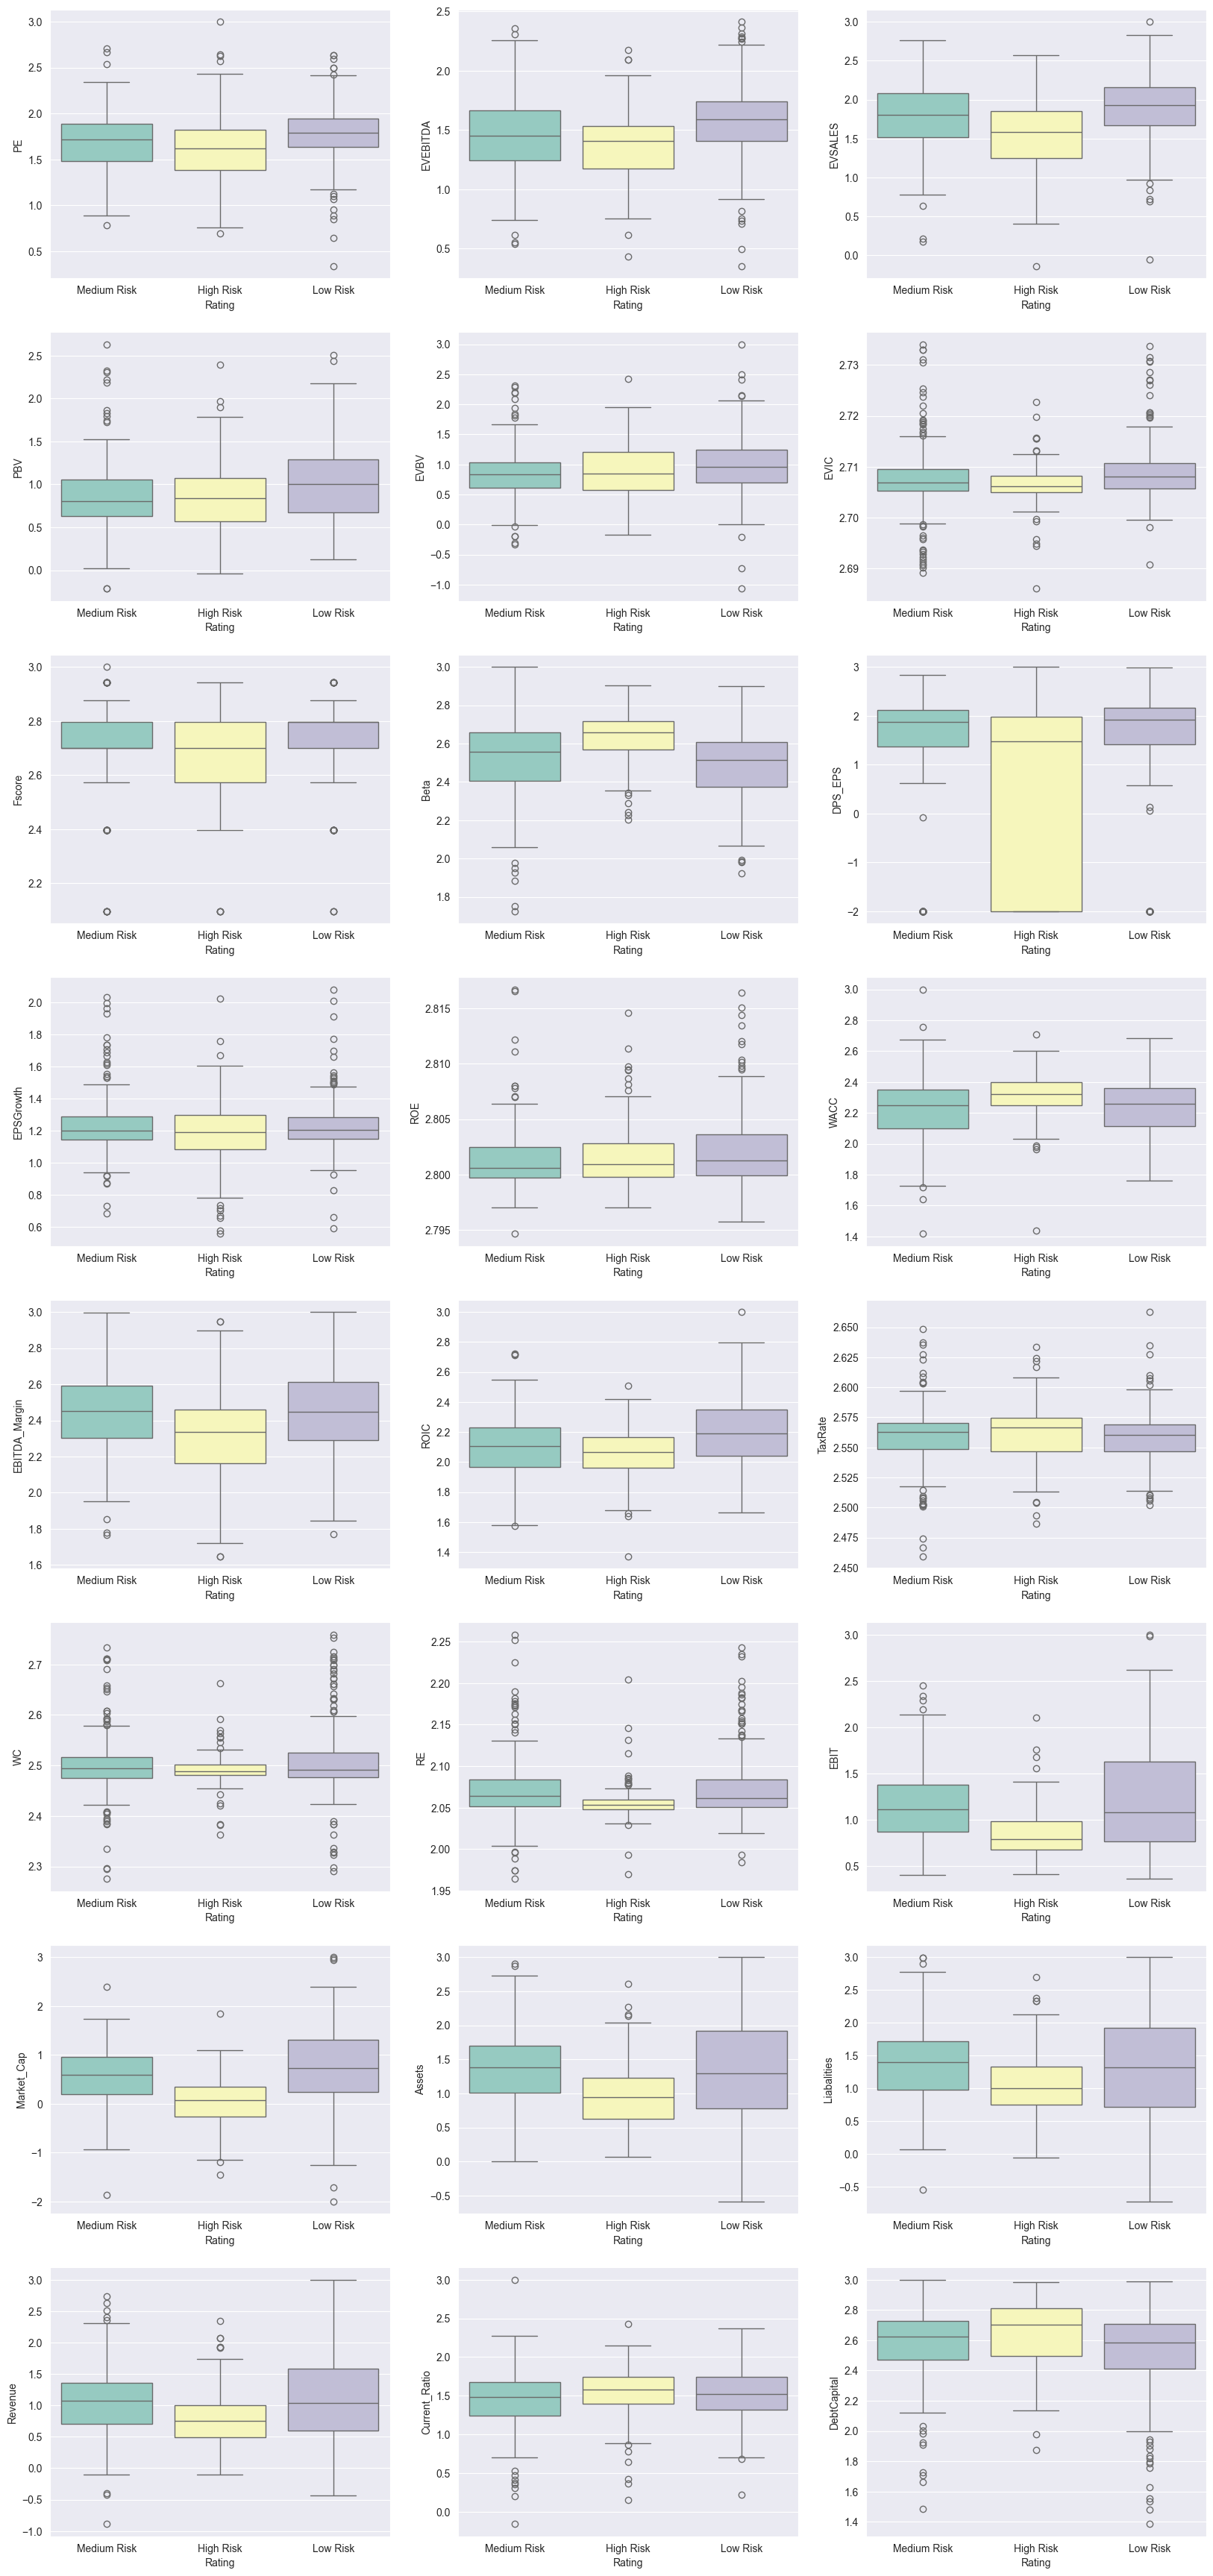

In [154]:

figure, axes = plt.subplots(nrows=8, ncols=3, figsize=(20,44))

i = 0
j = 0

columns_to_scale = df_rating_no_out.columns[np.r_[4:32]]

for c in columns_to_scale:

    sns.boxplot(x=df_rating_no_out.Rating, y=df_rating_no_out[c], palette="Set3", ax=axes[i, j])

    if j == 2:
        j=0
        i+=1
    else:
        j+=1


In [155]:
df.colors = 'a'

df_rating_no_out.loc[df_rating_no_out['Rating'] == 'Low Risk', 'color'] = 'Low Risk'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'Medium Risk', 'color'] = 'Medium Risk'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'High Risk','color'] = 'High Risk'


In [156]:

columns = df.columns[np.r_[4:32]]

column_list = list(columns)
column_list = sample(column_list,12)

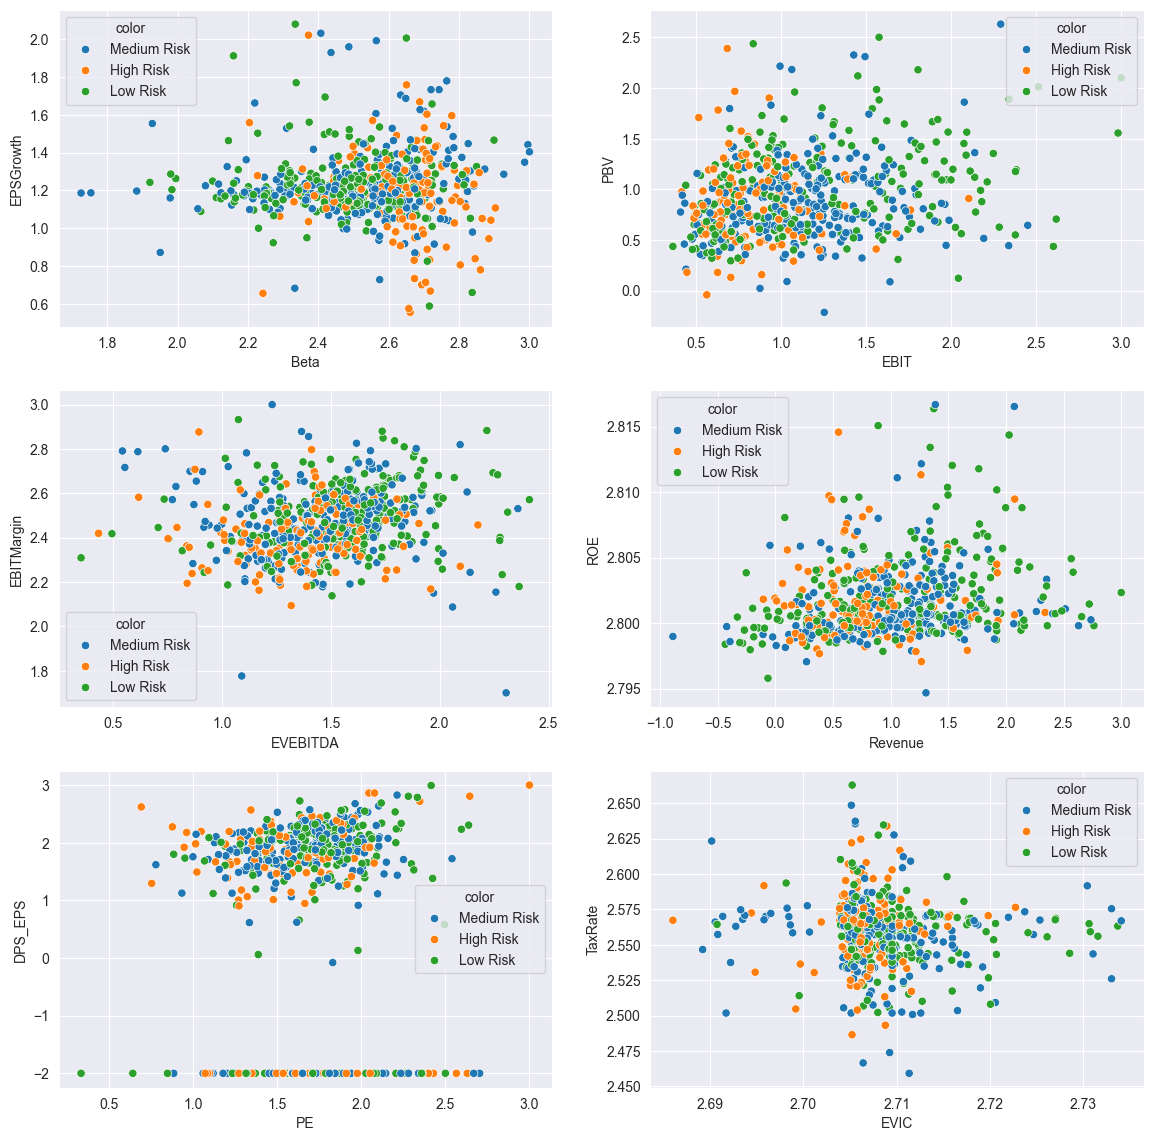

In [36]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,14))

i = 0
j = 0

for c in range(0,12, 2):

    sns.scatterplot(x = column_list[c], y=column_list[c+1], hue = 'color', data=df_rating_no_out, ax=axes[j,i])

    if i == 1:
        i = 0
        j +=1

    else:
        i+=1

### Encoding VARIABLES

En este modelo, se consideran algunas variables cualitativas: la industria y el país. Para poder considerar estas variables, estas se tienen que codificar para que puedan ser datos númericos.

In [157]:
df = df.drop(['Nombre'], axis=1)

In [223]:
le = preprocessing.LabelEncoder()

le.fit(df.Industria)
df.Industria= le.transform(df.Industria) # encode sector

le.fit(df.Pais)
df.Pais= le.transform(df.Pais) # encode país


In [225]:
df

,Nombre,Pais,Rating,PE,EVEBITDA,EVSALES,PBV,EVBV,Beta,DPS_EPS,...,EBIT,Market_Cap,Assets,Liabalities,Revenue,Current_Ratio,DebtCapital,NetProfitMargin,EBITMargin,Z-score
4,AGCO Corp,8,Medium Risk,1.129512,1.342436,1.326176,0.696305,0.545630,2.599314,2.001131,...,1.244581,0.304927,1.327867,1.357926,1.297085,1.496987,2.371000,2.304070,2.439057,2.621808
5,AES Corp,8,High Risk,1.386633,1.535842,2.003844,1.352136,1.834975,2.536914,2.053475,...,1.234030,0.538889,1.937087,2.124523,1.262715,1.023821,2.833668,2.454180,2.536389,0.503070
7,Abbott Laboratories,8,Low Risk,1.868972,1.779437,2.170294,1.145966,1.066518,2.378870,2.116237,...,1.904254,1.761123,2.152451,2.071718,1.784447,1.558513,2.417513,2.578088,2.518183,4.652774
13,Advanced Micro Devices Inc,8,Low Risk,2.264705,2.287192,2.516566,1.078173,0.961101,2.722547,-2.000000,...,1.651346,1.882140,2.119379,1.610780,1.539427,1.774543,1.481190,2.583449,2.233433,14.068485
15,Air Products and Chemicals Inc,8,Low Risk,1.891627,1.746893,2.299179,1.092719,1.059439,2.434020,2.233467,...,1.420781,1.301179,1.788893,1.746585,1.250977,1.447965,2.572568,2.627075,2.586752,3.311067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,Ashtead Group PLC,7,Medium Risk,1.728624,1.248828,2.058285,1.103380,1.144245,2.673653,1.875521,...,1.425887,0.969983,1.615638,1.696158,1.205097,1.353626,2.780062,2.505112,2.690407,2.363874
2939,BP PLC,7,Low Risk,1.168469,0.494243,1.210742,0.550283,0.570158,2.550317,2.007663,...,2.377309,1.396125,2.737833,2.826436,2.484243,1.392234,2.597426,2.256387,2.418178,1.440571
2988,AstraZeneca PLC,7,Low Risk,1.771132,1.682813,2.192125,1.181200,1.137096,2.134613,2.074807,...,2.111564,1.834729,2.293574,2.328209,1.866429,1.153554,2.547151,2.637601,2.556737,3.223077
2995,GSK plc,7,Low Risk,1.394328,1.199060,1.831586,1.093513,1.091338,2.299881,2.032864,...,1.998750,1.368031,2.163620,2.305621,1.770769,1.203468,2.705653,2.623019,2.663843,1.858730


In [224]:
df = df.drop(['Industria', 'EVIC', 'Fscore', 'ROIC', 'FCFFpS', 'Quick_Ratio', 'TaxRate'], axis=1)


In [160]:
df.dropna()
y = df['Rating']
x_2 = df.drop('Rating', axis=1)


### División de la base de datos

Se tomó la decisión de partir la base de datos, se utilizarán el 80% de los datos para entrenar el modelo, y el 20% para comprobar la validez del mismo. Para replicar este experimento, utilizar un *random_state* de 78

In [161]:
x_train, x_test, y_train, y_test = train_test_split(x_2, y, test_size=0.20, random_state=81)
data = pd.concat([x_train, y_train], axis=1)
data_clean = data.dropna(subset=[y_train.name])
x_train = data_clean.drop(columns=[y_train.name])
y_train = data_clean[y_train.name]

## Machine Learning Models

¿Es posible predecir qué perfil crediticio recibirá una empresa por parte de una agencia calificadora, basándonos en sus indicadores financieros?

En este apartado, se utiliza la información previa, y diversos modelos de Machine Learning para predecir el rating crediticio con base en la información dada. Cada uno de estos modelos brinda una *Accuracy*, la cual, una forma de interpretarlo sería, suponiendo una *Accuracy* de 62%, de 100 casos, el modelo puede predecir 62.

Para fines de este trabajo, se considera que una *Accuracy* buena debería ser superior a 60%.

Se utiliza la herramienta de la matriz de confusión y un análisis de cross validation score, con el objetivo de identificar las fortalezas de los modelos. La matriz de confusión se muestra únicamente en el modelo de la regresión logística y en la red neuronal.


### Logistic Regression

In [162]:
LR_model = LogisticRegression(random_state=1234 , multi_class='multinomial', solver='newton-cg', max_iter=10000)
LR_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=1234,
                   solver='newton-cg')

In [163]:
y_pred = LR_model.predict(x_test)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred)
print("Linear Regression Accuracy:",Accuracy_LR)


Linear Regression Accuracy: 0.6451612903225806


In [164]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[16  2 10]
 [ 1 28 13]
 [ 5 13 36]]


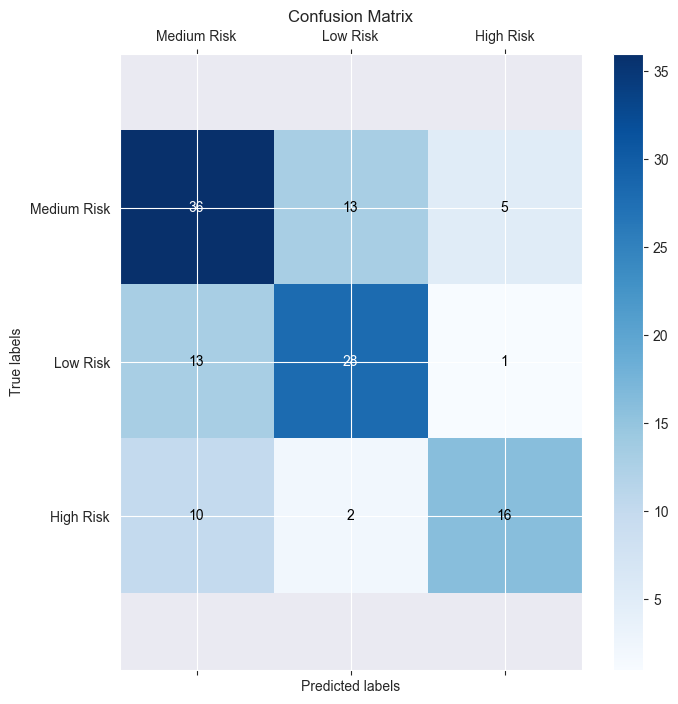

In [165]:

cm = confusion_matrix(y_test, y_pred, labels=['Medium Risk', 'Low Risk', 'High Risk'])

# Crear el gráfico
fig, ax = plt.subplots(figsize=(8, 8))

# Configurar etiquetas
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Crear el mapa de calor
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Agregar la barra de color
plt.colorbar(cax)

# Establecer ticks y etiquetas
ax.set_xticks(np.arange(len(['Medium Risk', 'Low Risk', 'High Risk'])))
ax.set_yticks(np.arange(len(['Medium Risk', 'Low Risk', 'High Risk'])))
ax.set_xticklabels(['Medium Risk', 'Low Risk', 'High Risk'])
ax.set_yticklabels(['Medium Risk', 'Low Risk', 'High Risk'])

# Anotar los valores en cada celda de la matriz
for i in range(len(['Medium Risk', 'Low Risk', 'High Risk'])):
    for j in range(len(['Medium Risk', 'Low Risk', 'High Risk'])):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > np.max(cm)/2 else 'black')

# Ajustar límites de los ejes
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

# Mostrar el gráfico
plt.show()



In [166]:
clas = classification_report(y_test, y_pred)

print(f'Classification Report:\n {clas}')


Classification Report:
               precision    recall  f1-score   support

   High Risk       0.73      0.57      0.64        28
    Low Risk       0.65      0.67      0.66        42
 Medium Risk       0.61      0.67      0.64        54

    accuracy                           0.65       124
   macro avg       0.66      0.63      0.65       124
weighted avg       0.65      0.65      0.65       124



### Gradient Boosting Classifier

In [167]:
GBT_model = GradientBoostingClassifier(random_state=123)
GBT_model.fit(x_train, y_train)
y_pred_GBT = GBT_model.predict(x_test)
Accuracy_GBT = metrics.accuracy_score(y_test, y_pred_GBT)
print("GBT Accuracy:",Accuracy_GBT)

GBT Accuracy: 0.532258064516129


### Random Forest

In [168]:
RF_model = RandomForestClassifier(random_state=1234)
RF_model.fit(x_train,y_train)
y_pred_RF = RF_model.predict(x_test)
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
print("RF Accuracy:",Accuracy_RF)

RF Accuracy: 0.5967741935483871


### Support Vector Machine

In [169]:
SVC_model = svm.SVC(kernel='rbf', gamma= 2, C = 5, random_state=1234)
SVC_model.fit(x_train, y_train)
y_pred_SVM = SVC_model.predict(x_test)
Accuracy_SVM = metrics.accuracy_score(y_test, y_pred_SVM)
print("SVM Accuracy:",Accuracy_SVM)

SVM Accuracy: 0.43548387096774194


### Naive Bayes

In [170]:
GNB_model = GaussianNB()
GNB_model.fit(x_train, y_train)
y_pred_GNB = GNB_model.predict(x_test)
Accuracy_GNB = metrics.accuracy_score(y_test, y_pred_GNB)
print("GNB Accuracy:",Accuracy_GNB)

GNB Accuracy: 0.45161290322580644


### Linear Discriminant Analysis

In [171]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(x_train,y_train)
y_pred_LDA = LDA_model.predict(x_test)
Accuracy_LDA = metrics.accuracy_score(y_test, y_pred_LDA)
print("LDA Accuracy:",Accuracy_LDA)

LDA Accuracy: 0.6048387096774194


### Quadrant Discriminant Analysis

In [172]:
QDA_model = QuadraticDiscriminantAnalysis()
QDA_model.fit(x_train,y_train)
y_pred_QDA = QDA_model.predict(x_test)
Accuracy_QDA = metrics.accuracy_score(y_test, y_pred_QDA)
print("QDA Accuracy:",Accuracy_QDA)

QDA Accuracy: 0.47580645161290325


### K Nearest Neighbours


In [173]:
KNN_model = KNeighborsClassifier(n_neighbors = 3)
KNN_model.fit(x_train,y_train)
y_pred_KNN = KNN_model.predict(x_test)
Accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print("KNN Accuracy:",Accuracy_KNN)

KNN Accuracy: 0.49193548387096775


### Neural Network

Tras obtener la red neuronal óptima, utilizando el Grid de opciones de redes y sus parámetros. Se obtuvo que la red neuronal óptima se obtiene utilizando 3 Hidden layers, de 60, 55 y 65 neuronas respectivamente. La primera capa de neuronas vendrían siendo las 24 variables dadas, y la capa del output serían las 3 posibles opciones: 'High Risk', 'Low Risk' y 'Medium Risk'

![](https://ricardogeek.com/wp-content/uploads/2018/04/Screen-Shot-2018-04-23-at-3.48.40-PM.png)

In [60]:

MLP_model = MLPClassifier(hidden_layer_sizes=(60,55,65), activation='relu', solver='sgd', max_iter=1500)
MLP_model.fit(x_train, y_train)
y_pred_MLP = MLP_model.predict(x_test)
Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)
print("MLP Accuracy:",Accuracy_MLP)


MLP Accuracy: 0.5967741935483871


In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

# Desired accuracy threshold
desired_accuracy = 0.60
Accuracy_MLP_2 = 0  # Initialize accuracy
iterations = 0    # Counter for the number of training iterations

# Continue training until the accuracy exceeds the threshold
while Accuracy_MLP_2 <= desired_accuracy:
    iterations += 1
    print(f"Iteration {iterations}: Training the MLP model...")

    # Define the model with the same hyperparameters
    MLP_model_2 = MLPClassifier(hidden_layer_sizes=(60,55,65), activation='relu', solver='sgd', max_iter=1500)

    # Fit the model
    MLP_model_2.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred_MLP_2 = MLP_model_2.predict(x_test)

    # Calculate accuracy
    Accuracy_MLP_2 = metrics.accuracy_score(y_test, y_pred_MLP_2)

    # Print the current accuracy
    print(f"MLP Accuracy after iteration {iterations}: {Accuracy_MLP_2 * 100:.2f}%")

    # Stop if accuracy is greater than 61%
    if Accuracy_MLP_2 > desired_accuracy:
        print(f"Desired accuracy of {desired_accuracy * 100:.2f}% reached!")
        break

In [62]:
# Desired accuracy threshold
desired_accuracy = 0.64
Accuracy_MLP_3 = 0  # Initialize accuracy
iterations = 0    # Counter for the number of training iterations

# Continue training until the accuracy exceeds the threshold
while Accuracy_MLP_3 <= desired_accuracy:
    iterations += 1
    print(f"Iteration {iterations}: Training the MLP model...")

    # Define the model with the same hyperparameters
    MLP_model_3 = MLPClassifier(hidden_layer_sizes=(60,55,65), activation='relu', solver='sgd', max_iter=1500)

    # Fit the model
    MLP_model_3.fit(x_train, y_train)

    # Make predictions on the test set
    y_pred_MLP_3 = MLP_model_3.predict(x_test)

    # Calculate accuracy
    Accuracy_MLP_3 = metrics.accuracy_score(y_test, y_pred_MLP_3)

    # Print the current accuracy
    print(f"MLP Accuracy after iteration {iterations}: {Accuracy_MLP_3 * 100:.2f}%")

    # Stop if accuracy is greater than 61%
    if Accuracy_MLP_3 > desired_accuracy:
        print(f"Desired accuracy of {desired_accuracy * 100:.2f}% reached!")
        break

Iteration 1: Training the MLP model...
MLP Accuracy after iteration 1: 59.68%
Iteration 2: Training the MLP model...
MLP Accuracy after iteration 2: 59.68%
Iteration 3: Training the MLP model...
MLP Accuracy after iteration 3: 58.06%
Iteration 4: Training the MLP model...
MLP Accuracy after iteration 4: 61.29%
Iteration 5: Training the MLP model...
MLP Accuracy after iteration 5: 59.68%
Iteration 6: Training the MLP model...
MLP Accuracy after iteration 6: 58.06%
Iteration 7: Training the MLP model...
MLP Accuracy after iteration 7: 58.06%
Iteration 8: Training the MLP model...
MLP Accuracy after iteration 8: 57.26%
Iteration 9: Training the MLP model...
MLP Accuracy after iteration 9: 58.87%
Iteration 10: Training the MLP model...
MLP Accuracy after iteration 10: 57.26%
Iteration 11: Training the MLP model...
MLP Accuracy after iteration 11: 56.45%
Iteration 12: Training the MLP model...
MLP Accuracy after iteration 12: 61.29%
Iteration 13: Training the MLP model...
MLP Accuracy after

Grid de opciones

In [ ]:

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Define el modelo
MLP_model = MLPClassifier()

# Define los hiperparámetros que quieres probar en la búsqueda de grid
param_grid = {
    'hidden_layer_sizes': [(60,50,65), (50,50,50), (70,45,60)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'sgd'],
    'max_iter': [15000]
}

# Implementación de GridSearchCV
grid_search = GridSearchCV(estimator=MLP_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(x_train, y_train)

# Obtiene los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Predice usando el mejor modelo encontrado
best_MLP_model = grid_search.best_estimator_
y_pred_MLP = best_MLP_model.predict(x_test)

# Calcula la precisión del modelo
Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)
print("MLP Accuracy con los mejores parámetros:", Accuracy_MLP)


In [177]:
cm_MLP = confusion_matrix(y_test, y_pred_MLP_3)
print(cm_MLP)

[[18  1  9]
 [ 5 24 13]
 [ 9  7 38]]


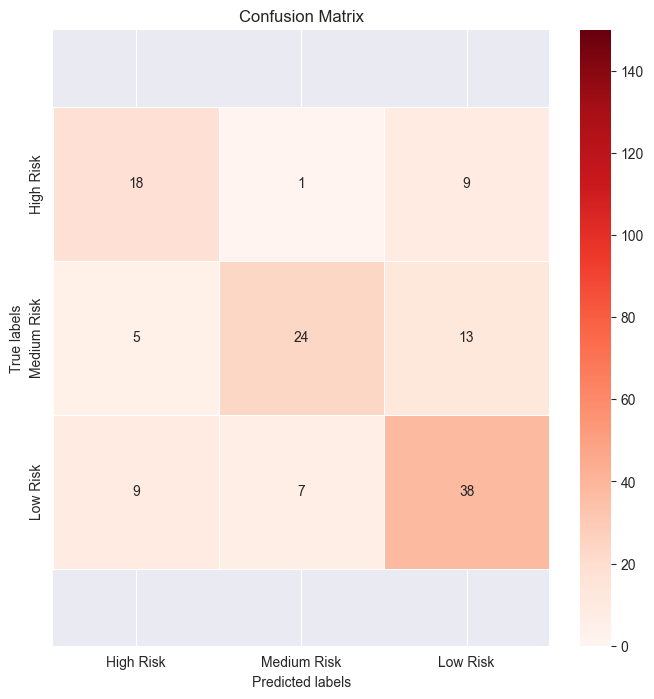

In [176]:
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm_MLP, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['High Risk', 'Medium Risk', 'Low Risk'])
ax.yaxis.set_ticklabels(['High Risk', 'Medium Risk', 'Low Risk']);

# This part is to correct a bug from the heatmap funciton from pyplot
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

### XGBoost

In [178]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
XGB_model = xgb.XGBRegressor(objective='multi:softmax', num_class=4)
XGB_model.fit(x_train, y_train_encoded)
y_test_encoded = label_encoder.transform(y_test)
y_pred_XGB = XGB_model.predict(x_test)
Accuracy_XGB = metrics.accuracy_score(y_test_encoded, y_pred_XGB)

print("XGB Accuracy:", Accuracy_XGB)


XGB Accuracy: 0.5967741935483871


### Comparación de los modelos por *Accuracy*

A continuación se muestra una comparativa de los modelos, se observa que tanto el Linear discriminant analysis y la red neuronal tienen una 'Accuracy' aceptable.

In [179]:
accuracy_list = [Accuracy_XGB, Accuracy_GBT, Accuracy_RF, Accuracy_SVM, Accuracy_MLP_3, Accuracy_GNB,
                 Accuracy_LDA, Accuracy_QDA, Accuracy_KNN, Accuracy_LR]

model_list = ['XGBboost', 'Gradient Boosting', 'Random Forest', 'Support Vector Machine',
              "Neural Network", 'Naive Bayes', 'Linear Discriminat', 'Quadratic Discriminat',
              'KNN', 'Logistic Regression']

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})

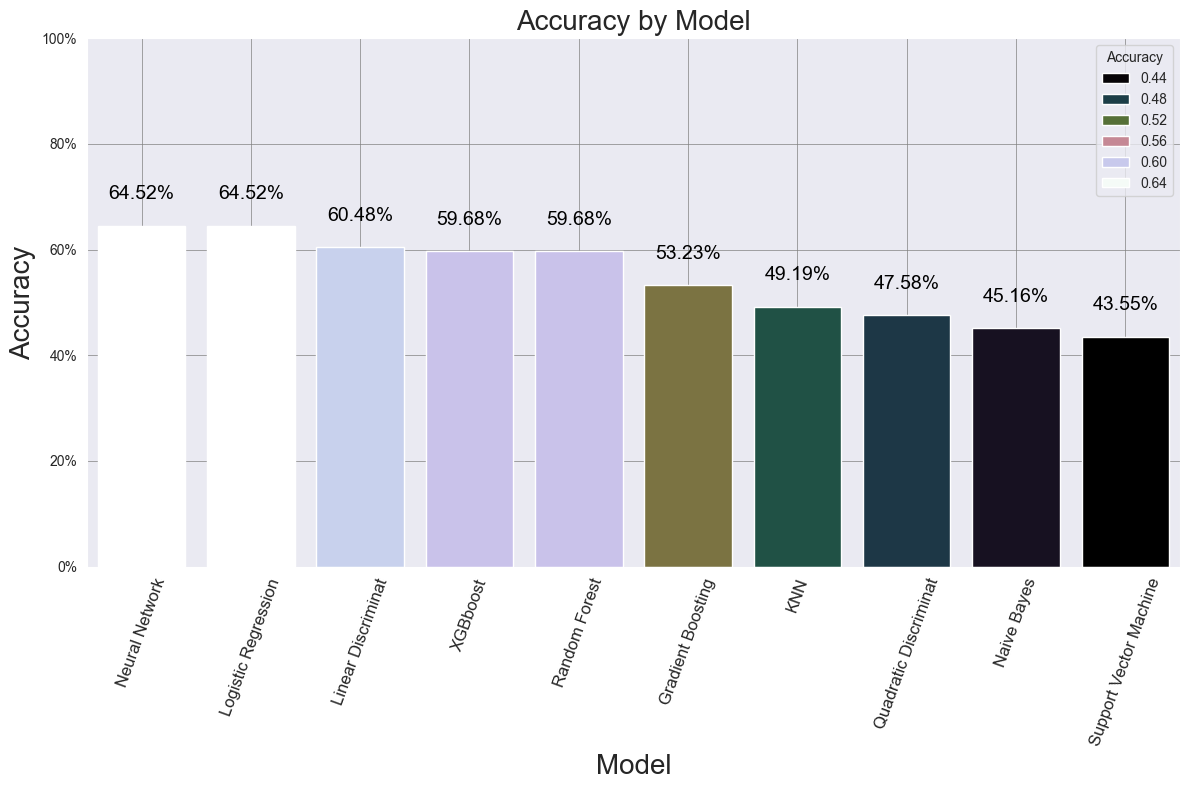

In [180]:
order = list(df_accuracy.sort_values('Accuracy', ascending=False).Model)
df_accuracy = df_accuracy.sort_values('Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(12,8))
# make barplot and sort bars
x = sns.barplot(x='Model', y="Accuracy", data=df_accuracy, order = order, palette="cubehelix", hue="Accuracy")
plt.xlabel("Model", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy by Model", fontsize=20)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_accuracy.loc[i, 'Accuracy'] + 0.05, s = str(round((df_accuracy.loc[i, 'Accuracy'])*100, 2))+'%',
             fontsize = 14, color='black',horizontalalignment='center')

y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)

plt.tight_layout()

### Importancia de cada parámetro para la red neuronal

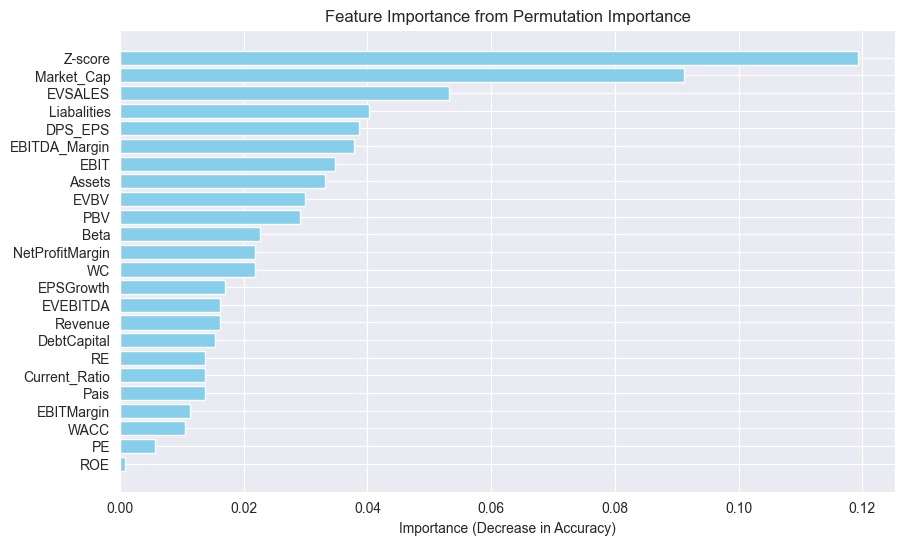

In [181]:
from sklearn.inspection import permutation_importance


# Assuming 'nn_model' is your trained neural network model
# and 'x_test', 'y_test' are your test data
result = permutation_importance(MLP_model_3, x_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame with the feature importances
feature_importance = pd.DataFrame({
    'Feature': x_test.columns,
    'Importance': result.importances_mean
})

# Sort the feature importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance (Decrease in Accuracy)')
plt.title('Feature Importance from Permutation Importance')
plt.show()


### Pruebas

En este apartado, se consigue información únicamente de las empresas mexicanas, y se aplica el algoritmo escogido. En esta base de datos también se encuentra Bimbo (BMV: BIMBOA). Se le está realizando la misma limpieza de los datos que se realizó a la base de datos original.

In [227]:
new_data = pd.read_excel('/Users/diegosalazar/Documents/Valuación de Empresas/Modulo 2/Copia de BimboNuevo 3.xlsx')


In [228]:
new_data = new_data.drop(['DividendYield'], axis=1)
new_data = new_data.dropna()

In [229]:

new_data.loc[:, 'Rating'] = new_data['Rating'].map(rating_dict)
new_data['Z-score'] = 1.2 * new_data['WC']/new_data['Assets'] + 1.4 * new_data['RE']/new_data['Assets'] + 3.3 * new_data['EBIT']/new_data['Assets'] + 0.6 * new_data['Market_Cap']/new_data['Liabalities'] + 1 * new_data['Revenue']/new_data['Assets']
new_data = new_data.drop(['Ticker'], axis=1)

min_max_scaler = preprocessing.MinMaxScaler()

columns_to_scale = new_data.columns[np.r_[4:32]]

for c in columns_to_scale:
    new_data[[c]] = min_max_scaler.fit_transform(new_data[[c]]) * 1000
    new_data[c] = new_data[c].apply(lambda x: np.log10(x + 0.01))

names = new_data['Nombre'].copy()  # Guarda los nombres para usarlos en el output
new_data = new_data.drop(['Nombre'], axis=1)

#le.fit(new_data.Industria)
#new_data['Industria'] = le.transform(new_data['Industria'])  # encode sector

#le.fit(new_data.Pais)
#new_data['Pais'] = le.transform(new_data['Pais'])  # encode country

new_data = new_data.drop(['Industria', 'EVIC', 'Fscore', 'ROIC', 'FCFFpS', 'Quick_Ratio', 'TaxRate'], axis=1)

x_new = new_data.drop(['Rating'], axis =1)




In [230]:
x_new

,Pais,PE,EVEBITDA,EVSALES,PBV,EVBV,Beta,DPS_EPS,EPSGrowth,ROE,...,EBIT,Market_Cap,Assets,Liabalities,Revenue,Current_Ratio,DebtCapital,NetProfitMargin,EBITMargin,Z-score
2,5,2.922778,2.953334,2.411373,2.530098,2.226366,2.122685,2.686574,2.852911,3.000004,...,2.276304,2.555065,2.214280,2.055468,2.485247,2.168716,2.428550,2.917077,2.138143,2.780511
7,5,1.706266,2.973270,2.114214,2.698876,2.554269,1.119501,2.366262,2.383373,1.959844,...,2.295434,2.434132,2.326559,2.299011,2.668906,1.397194,2.726274,1.579228,1.800354,1.987257
8,5,1.627555,2.859702,2.183007,2.730945,2.526674,-2.000000,2.336067,1.467318,2.467187,...,1.825838,2.039745,1.579955,1.513026,2.082528,2.407853,2.554462,2.111976,2.032190,3.666926
9,5,1.205192,2.648747,3.000004,2.114593,-2.000000,2.488900,2.504808,1.654166,2.162615,...,1.606679,1.728310,1.561314,0.872759,-0.338500,3.000004,-2.000000,3.000004,3.000004,2.981370
14,5,3.000004,2.448869,1.880975,0.792453,1.172945,2.815580,-2.000000,3.000004,2.369273,...,2.303043,2.223856,2.475520,2.370289,2.558346,1.585985,2.521841,2.485141,2.033493,1.136829
15,5,1.434581,2.714560,2.880812,2.423959,2.078689,2.784428,2.708634,1.676390,2.249592,...,2.776189,2.941567,2.571220,2.287153,2.496818,2.977380,2.271771,2.670015,2.788317,3.268056
17,5,2.275973,2.765425,1.935307,2.129701,2.366281,2.805927,3.000004,2.968278,-2.000000,...,1.838097,1.269335,2.054868,2.060439,2.163115,2.375791,2.807960,-2.000000,1.883223,1.201819
18,5,1.479637,2.519042,2.141806,3.000004,3.000004,3.000004,-2.000000,-2.000000,2.538844,...,1.456381,1.316371,1.565172,1.698904,1.877198,-2.000000,3.000004,1.537230,1.900798,1.527685
19,5,1.669691,3.000004,2.492436,2.612547,2.370463,1.613155,2.743453,1.496324,2.196146,...,2.288000,2.491169,2.150396,1.916520,2.390227,2.116757,0.385005,2.189677,2.254984,3.003566
20,5,-2.000000,2.179202,2.466869,2.390937,1.768859,2.529925,2.036917,1.096241,2.269943,...,1.291353,1.467229,1.242391,0.759128,0.987528,2.928914,1.856796,2.682258,2.575993,3.031199


In [231]:
pred = MLP_model_3.predict(x_new)

output = pd.DataFrame({'Nombre': names, 'Predicted Rating': pred})
print(output.head(14))


                                               Nombre Predicted Rating
2                           Coca-Cola Femsa SAB de CV         Low Risk
7                               Grupo Bimbo SAB de CV         Low Risk
8                                     Gruma SAB de CV         Low Risk
9   Promotora y Operadora de Infraestructura SAB d...         Low Risk
14                                    Cemex SAB de CV         Low Risk
15                             Grupo Mexico SAB de CV         Low Risk
17                Orbia Advance Corporation SAB de CV         Low Risk
18                                    Alsea SAB de CV        High Risk
19                         Arca Continental SAB de CV         Low Risk
20                                      GCC SAB de CV         Low Risk
23                       Megacable Holdings SAB de CV      Medium Risk
25                Genomma Lab Internacional SAB de CV         Low Risk
26                 Grupo Comercial Chedraui SAB de CV         Low Risk
34    

### Conclusión

Se hace la invitación al lector a seguir haciendo pruebas con el código, nuevos modelos, etc. Para obtener una mejor **Accuracy** en esta clase de modelos predictivos.

Al final, según la red neuronal planteada, Bimbo debería ser catalogada como una empresa 'Low Risk'. Entrando en las categorías 'A' de las agencias calificadoras principales. Siendo que actualmente se encuentra en la categoría Baa1